In [1]:
!pip install tensorly
!pip install lifelines

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.7/229.7 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.7/350.7 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.0/91.0 kB 9.0 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=12b765a3447ff08a614794dbf9babce2612f959e59c137d3ae38f88d9e173f1c
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
from tensorly.decomposition import parafac
from tensorly.decomposition import non_negative_parafac


#  Load your data
rnaseq_df = pd.read_excel('/content/drive/MyDrive/RNAseq_128_filtered.xlsx').set_index('attrib_name')
mirna_df = pd.read_excel('/content/drive/MyDrive/miRNASeq_128_filtered.xlsx').set_index('attrib_name')
methylation_df = pd.read_excel('/content/drive/MyDrive/Methylation_128_filtered.xlsx').set_index('attrib_name')
image_df = pd.read_excel('/content/drive/MyDrive/images_128_filtered.xlsx').set_index('attrib_name')

# Join dataframes based on the index
merged_data = methylation_df.join([rnaseq_df, mirna_df, image_df], how='inner')




# Extract aligned datasets
methylation_data_aligned = merged_data[methylation_df.columns].to_numpy()
rnaseq_data_aligned = merged_data[rnaseq_df.columns].to_numpy()
mirna_data_aligned = merged_data[mirna_df.columns].to_numpy()
image_data_aligned = merged_data[image_df.columns].to_numpy()

# Create the 3D tensor
multi_omics_tensor = np.array([methylation_data_aligned, rnaseq_data_aligned, mirna_data_aligned, image_data_aligned], dtype=object)

# Reorder the tensor
multi_omics_tensor_transposed = np.transpose(multi_omics_tensor, (1, 0, 2))
multi_omics_tensor_transposed = multi_omics_tensor_transposed.astype(np.float64)

# Store the indexes
sample_indexes = merged_data.index.tolist()

print(multi_omics_tensor_transposed.shape)
print(sample_indexes)


(448, 4, 128)
['TCGA.05.4384', 'TCGA.05.4384', 'TCGA.05.4390', 'TCGA.05.4396', 'TCGA.05.4405', 'TCGA.05.4410', 'TCGA.05.4415', 'TCGA.05.4417', 'TCGA.05.4424', 'TCGA.05.4425', 'TCGA.05.4427', 'TCGA.05.4433', 'TCGA.05.5420', 'TCGA.05.5423', 'TCGA.05.5425', 'TCGA.05.5428', 'TCGA.05.5429', 'TCGA.05.5715', 'TCGA.35.5375', 'TCGA.38.4631', 'TCGA.38.4632', 'TCGA.38.6178', 'TCGA.38.7271', 'TCGA.38.A44F', 'TCGA.44.5643', 'TCGA.44.5644', 'TCGA.44.5645', 'TCGA.44.6145', 'TCGA.44.6146', 'TCGA.44.6147', 'TCGA.44.6148', 'TCGA.44.6774', 'TCGA.44.6775', 'TCGA.44.6776', 'TCGA.44.6777', 'TCGA.44.6778', 'TCGA.44.6779', 'TCGA.44.7659', 'TCGA.44.7660', 'TCGA.44.7661', 'TCGA.44.7662', 'TCGA.44.7667', 'TCGA.44.7669', 'TCGA.44.7670', 'TCGA.44.7671', 'TCGA.44.7672', 'TCGA.44.8117', 'TCGA.44.8119', 'TCGA.44.8120', 'TCGA.44.A479', 'TCGA.44.A47A', 'TCGA.44.A47B', 'TCGA.44.A47G', 'TCGA.44.A4SS', 'TCGA.44.A4SU', 'TCGA.49.4487', 'TCGA.49.4488', 'TCGA.49.4490', 'TCGA.49.4512', 'TCGA.49.4514', 'TCGA.49.6742', 'TCGA.49.

In [4]:


# CP decomposition
rank = 4 # the rank of CP decomposition, which can be motified
factors = parafac(multi_omics_tensor_transposed, rank=rank)

print(factors)

# obtain weights and factors
weights = factors[0]
factor_matrices = factors[1]  # This is a list that contains 3 factors array

# patient’s mode
patient_mode_matrix = factor_matrices[0]
print(patient_mode_matrix.shape)
# omics feature mode
omics_feature_mode_matrix = factor_matrices[1]
print(omics_feature_mode_matrix.shape)
# genes mode
genes_mode_matrix = factor_matrices[2]
print(genes_mode_matrix.shape)

(weights, factors) : rank-4 CPTensor of shape (448, 4, 128)
(448, 4)
(4, 4)
(128, 4)


In [5]:
# Convert patient_mode_matrix to a DataFrame with index
patient_df = pd.DataFrame(patient_mode_matrix, index=sample_indexes)

In [6]:
patient_df

,0,1,2,3
TCGA.05.4384,19.996500,12.396028,-1.575148e-14,2.281373e-16
TCGA.05.4384,19.996500,12.396028,-1.575148e-14,2.281373e-16
TCGA.05.4390,23.001894,7.637105,1.367871e-15,-2.529322e-16
TCGA.05.4396,20.943601,13.679057,-1.688260e-14,-2.371713e-16
TCGA.05.4405,21.834325,13.320472,-1.412922e-14,-1.469516e-16
...,...,...,...,...
TCGA.NJ.A55O,20.097748,12.508551,-2.871547e-15,4.197963e-16
TCGA.NJ.A55R,21.390161,13.211211,5.296641e-16,2.762684e-16
TCGA.NJ.A7XG,20.861224,7.968359,-1.450833e-14,4.466422e-16
TCGA.O1.A52J,17.805123,11.930284,5.670589e-15,4.619701e-16


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from sklearn.model_selection import train_test_split
from lifelines import KaplanMeierFitter
from scipy.cluster.hierarchy import linkage, fcluster

# 1. import clinical.xlsx
data_methylation = pd.read_excel('/content/drive/MyDrive/Methylation_128_filtered.xlsx')
data_clinical = pd.read_excel('/content/drive/MyDrive/Clinical_lung.xlsx')
#data_clinical = data_clinical.dropna()
selected_samples = data_methylation.iloc[:, 0].unique()
data = data_clinical[data_clinical['attrib_name'].isin(selected_samples)]



# 1. Delete columns in “overall_survival” and “status” that contains "NA"
data = data.dropna(subset=['overall_survival', 'status'])

# 2. Change "NA" in numerical attributes to 0
num_cols = data.select_dtypes(include=['float64', 'int64']).columns
data[num_cols] = data[num_cols].fillna(0)

# 3. Change "NA" in character attributes to "No value"
text_cols = data.select_dtypes(include=['object']).columns
data[text_cols] = data[text_cols].fillna('No value')


# Merge the two dataframes on the 'attrib_name' column and the index of patient_df
merged_data = pd.merge(data, patient_df, left_on='attrib_name', right_index=True)

# The result will be a dataframe where each row contains both the clinical data and the corresponding patient_mode_matrix values.



In [8]:
merged_data

,attrib_name,years_to_birth,Tumor_purity,pathologic_stage,pathology_T_stage,pathology_N_stage,pathology_M_stage,histological_type,gender,radiation_therapy,residual_tumor,race,ethnicity,overall_survival,status,overallsurvival,0,1,2,3
2,TCGA.05.4384,66.0,0.6937,stageiii,t2,n2,m0,lungadenocarcinomamixedsubtype,male,yes,No value,No value,No value,426.0,0.0,"426,0",19.996500,12.396028,-1.575148e-14,2.281373e-16
2,TCGA.05.4384,66.0,0.6937,stageiii,t2,n2,m0,lungadenocarcinomamixedsubtype,male,yes,No value,No value,No value,426.0,0.0,"426,0",19.996500,12.396028,-1.575148e-14,2.281373e-16
3,TCGA.05.4396,76.0,0.8575,stageiii,t4,n1,m0,lungadenocarcinomamixedsubtype,male,No value,r0,No value,No value,303.0,1.0,"303,1",20.943601,13.679057,-1.688260e-14,-2.371713e-16
5,TCGA.05.4405,74.0,0.5920,stagei,t2,n0,m0,lungadenocarcinomamixedsubtype,female,no,r0,No value,No value,610.0,0.0,"610,0",21.834325,13.320472,-1.412922e-14,-1.469516e-16
8,TCGA.05.4427,65.0,0.6325,stageii,t2,n1,m0,lungadenocarcinomamixedsubtype,female,no,r0,No value,No value,791.0,0.0,"791,0",20.506906,13.113854,-1.219977e-14,-2.730942e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,TCGA.NJ.A4YQ,69.0,0.4331,stagei,t1,n0,m0,lungadenocarcinoma-nototherwisespecified(nos),female,no,No value,white,nothispanicorlatino,1432.0,0.0,"1432,0",24.198474,12.686010,1.118778e-14,3.703455e-16
518,TCGA.NJ.A55R,67.0,0.7913,stagei,t1,n0,No value,lungadenocarcinoma-nototherwisespecified(nos),male,no,No value,white,nothispanicorlatino,603.0,0.0,"603,0",21.390161,13.211211,5.296641e-16,2.762684e-16
519,TCGA.NJ.A7XG,49.0,0.7730,stageiii,t4,n1,m0,lungadenocarcinoma-nototherwisespecified(nos),male,no,No value,blackorafricanamerican,nothispanicorlatino,617.0,0.0,"617,0",20.861224,7.968359,-1.450833e-14,4.466422e-16
520,TCGA.O1.A52J,74.0,0.6489,stagei,t1,n0,No value,lungadenocarcinoma-nototherwisespecified(nos),female,no,No value,white,nothispanicorlatino,1798.0,1.0,"1798,1",17.805123,11.930284,5.670589e-15,4.619701e-16


In [9]:
count_status = merged_data['status'].value_counts()
print(count_status)


0.0    276
1.0    152
Name: status, dtype: int64


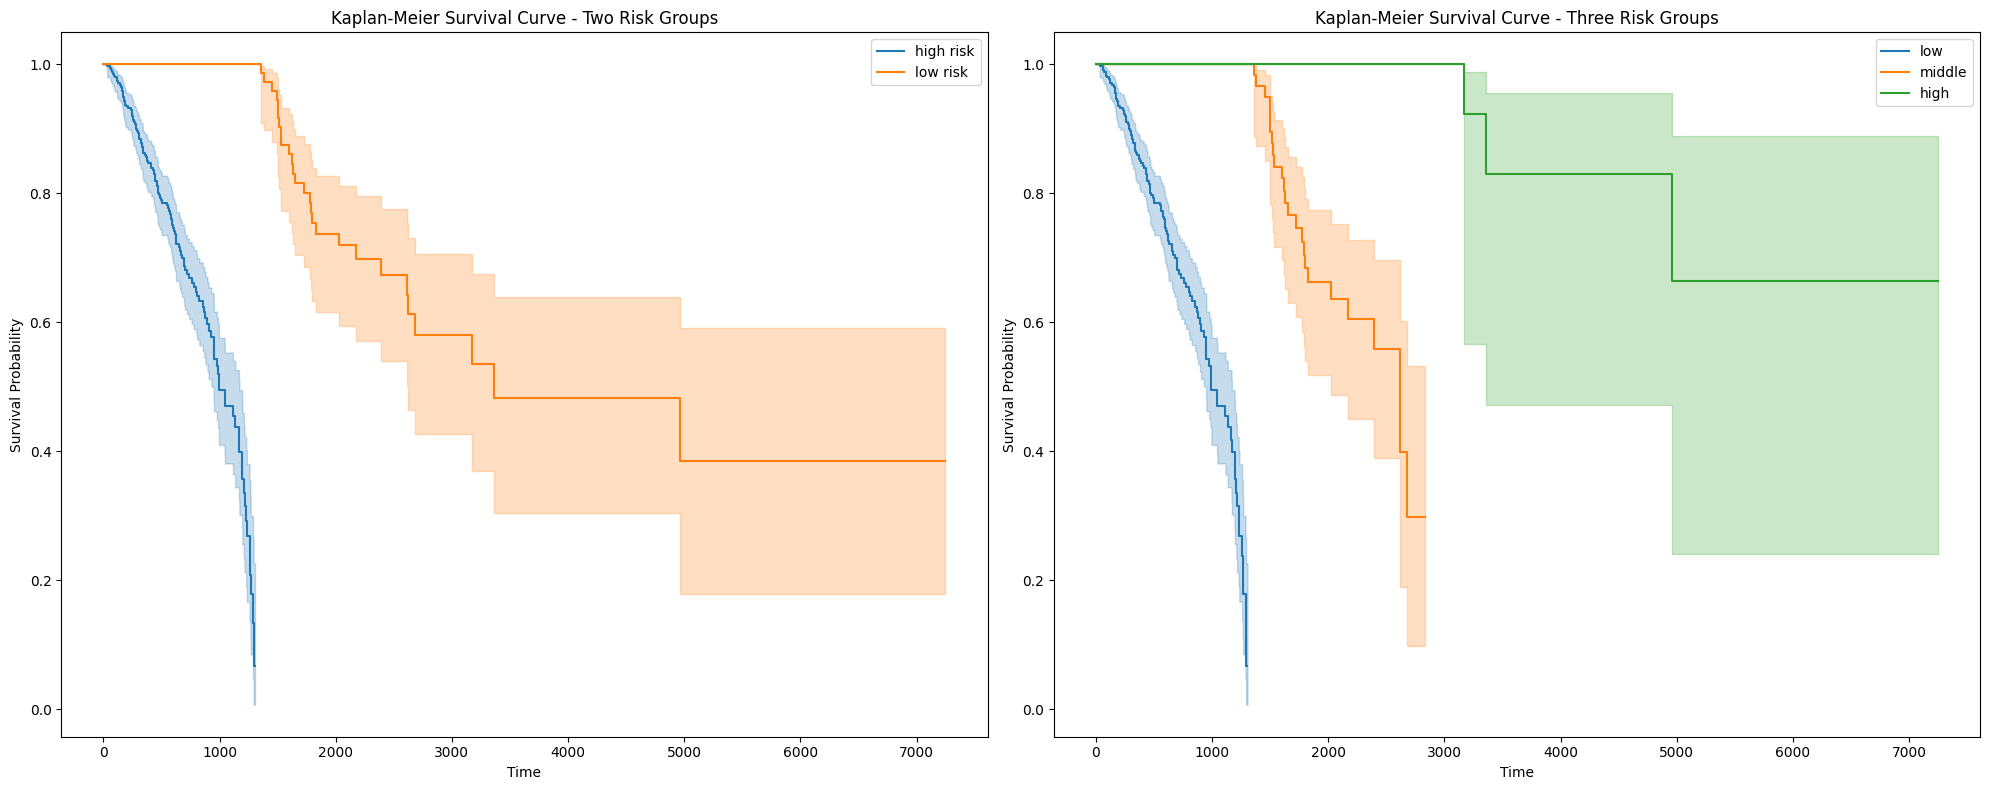

In [10]:
#In this process, because the dataframe contains overall_survival and status, Which causes overfitting, so the model performs very well


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster
from lifelines import KaplanMeierFitter


numeric_data = merged_data.select_dtypes(include=[np.number])


linked = linkage(numeric_data, 'ward')

# bulid 2 and 3 risk groups
label_2_clusters = fcluster(linked, 2, criterion='maxclust')
label_3_clusters = fcluster(linked, 3, criterion='maxclust')

# copy merged_data to processed_data
processed_data = merged_data.copy()

# add labels to the new dataframe
processed_data['risk_group_2'] = label_2_clusters
processed_data['risk_group_3'] = label_3_clusters


kmf = KaplanMeierFitter()

# apply Kaplan-Meier survival analyse for 2 risk groups
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
risk_labels_2 = {1: "high risk", 2: "low risk"}
for label in np.unique(label_2_clusters):
    mask = processed_data['risk_group_2'] == label
    group_data = processed_data[mask]

    kmf.fit(group_data['overall_survival'], event_observed=group_data['status'], label=risk_labels_2[label])
    kmf.plot(ax=plt.gca())

plt.title('Kaplan-Meier Survival Curve - Two Risk Groups')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# apply Kaplan-Meier survival analyse for 3 risk groups
plt.subplot(1, 2, 2)
risk_labels_3 = {1: "low", 2: "middle", 3: "high"}
for label in np.unique(label_3_clusters):
    mask = processed_data['risk_group_3'] == label
    group_data = processed_data[mask]

    kmf.fit(group_data['overall_survival'], event_observed=group_data['status'], label=risk_labels_3[label])
    kmf.plot(ax=plt.gca())

plt.title('Kaplan-Meier Survival Curve - Three Risk Groups')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

plt.tight_layout()
plt.show()





In [11]:

from lifelines.statistics import logrank_test

# Calculate P-value for 2 riks groups
group1 = processed_data[processed_data['risk_group_2'] == 1]
group2 = processed_data[processed_data['risk_group_2'] == 2]
results_2 = logrank_test(group1['overall_survival'], group2['overall_survival'], event_observed_A=group1['status'], event_observed_B=group2['status'])
p_value_2 = results_2.p_value
print(f"P-value for the difference between two risk groups: {p_value_2}")

# Calculate P-value for 3 riks groups
group1 = processed_data[processed_data['risk_group_3'] == 1]
group2 = processed_data[processed_data['risk_group_3'] == 2]
group3 = processed_data[processed_data['risk_group_3'] == 3]

results_3_12 = logrank_test(group1['overall_survival'], group2['overall_survival'], event_observed_A=group1['status'], event_observed_B=group2['status'])
results_3_13 = logrank_test(group1['overall_survival'], group3['overall_survival'], event_observed_A=group1['status'], event_observed_B=group3['status'])
results_3_23 = logrank_test(group2['overall_survival'], group3['overall_survival'], event_observed_A=group2['status'], event_observed_B=group3['status'])

print(f"P-value for the difference between risk groups 1 and 2: {results_3_12.p_value}")
print(f"P-value for the difference between risk groups 1 and 3: {results_3_13.p_value}")
print(f"P-value for the difference between risk groups 2 and 3: {results_3_23.p_value}")

P-value for the difference between two risk groups: 1.1390160577928173e-21
P-value for the difference between risk groups 1 and 2: 1.1484978635177331e-18
P-value for the difference between risk groups 1 and 3: 2.3772618535908522e-07
P-value for the difference between risk groups 2 and 3: 0.00019897991764640914


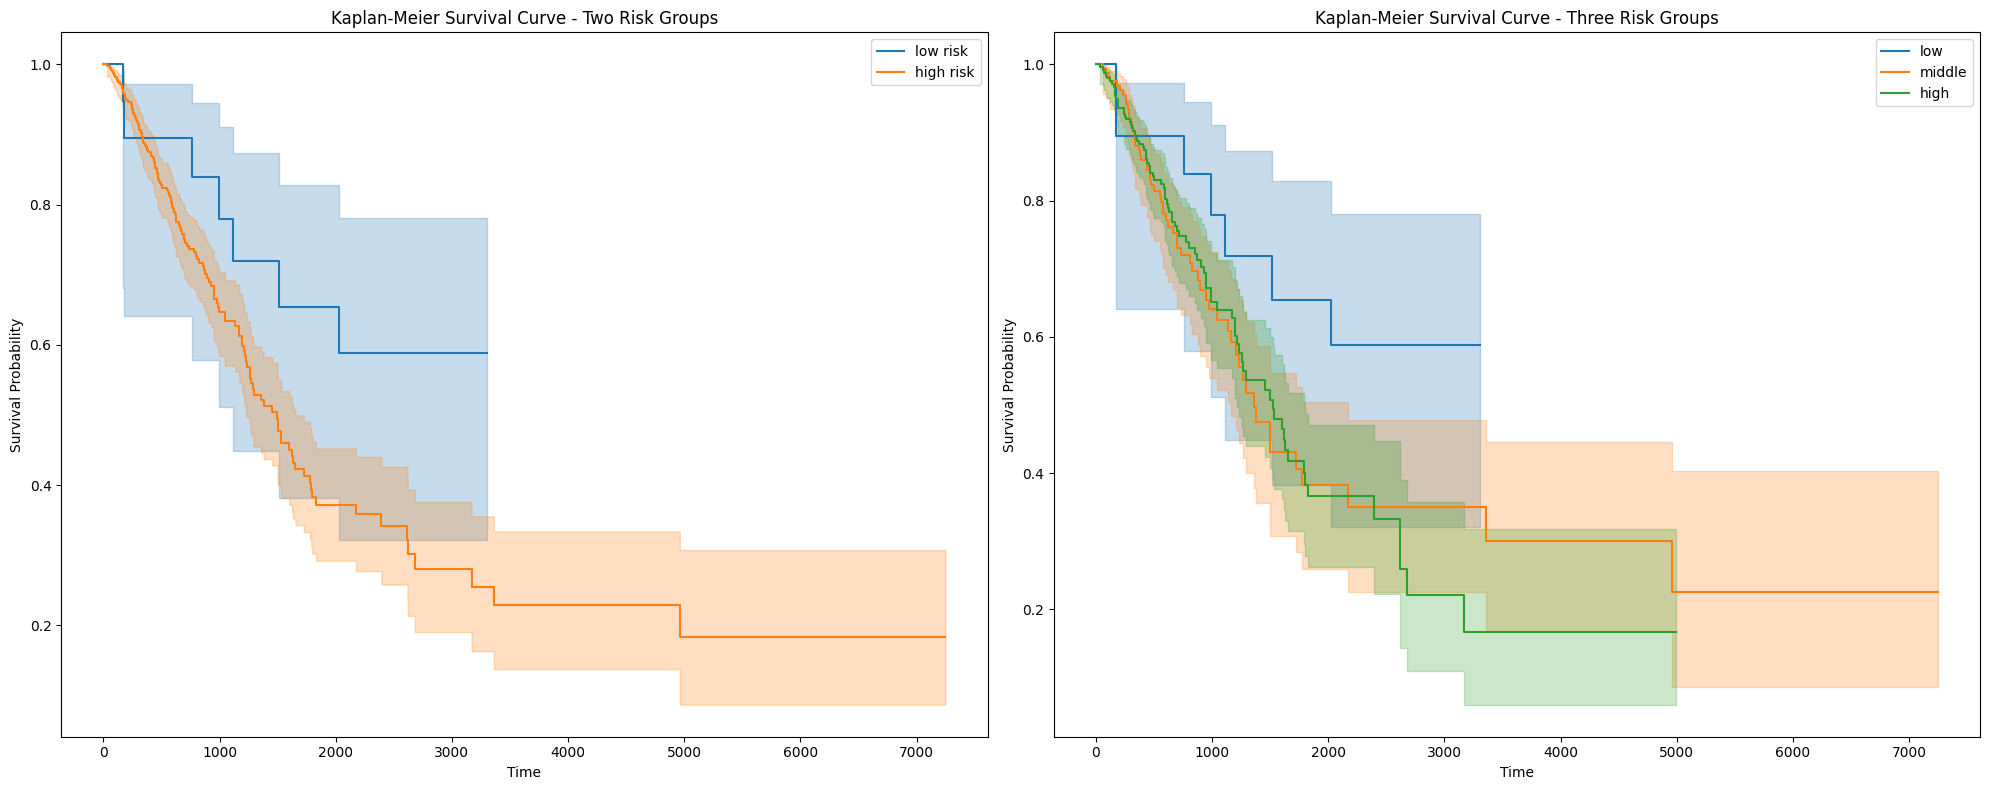

In [12]:
# Based on the precious result, delete "overall_survival", 'status',"Median_overall_survival"
new_df = merged_data.drop(columns=['overall_survival', 'status'])
numeric_data_new = new_df.select_dtypes(include=[np.number])


linked = linkage(numeric_data_new, 'ward')


label_2_clusters = fcluster(linked, 2, criterion='maxclust')
label_3_clusters = fcluster(linked, 3, criterion='maxclust')

processed_data_new = merged_data.copy()


processed_data_new['risk_group_2'] = label_2_clusters
processed_data_new['risk_group_3'] = label_3_clusters


kmf = KaplanMeierFitter()

# apply Kaplan-Meier survival analyse for 2 risk groups
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
risk_labels_2 = {1: "low risk", 2: "high risk"}
for label in np.unique(label_2_clusters):
    mask = processed_data_new['risk_group_2'] == label
    group_data = processed_data_new[mask]

    kmf.fit(group_data['overall_survival'], event_observed=group_data['status'], label=risk_labels_2[label])
    kmf.plot(ax=plt.gca())

plt.title('Kaplan-Meier Survival Curve - Two Risk Groups')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# apply Kaplan-Meier survival analyse for 3 risk groups
plt.subplot(1, 2, 2)
risk_labels_3 = {1: "low", 2: "middle", 3: "high"}
for label in np.unique(label_3_clusters):
    mask = processed_data_new['risk_group_3'] == label
    group_data = processed_data_new[mask]

    kmf.fit(group_data['overall_survival'], event_observed=group_data['status'], label=risk_labels_3[label])
    kmf.plot(ax=plt.gca())

plt.title('Kaplan-Meier Survival Curve - Three Risk Groups')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

plt.tight_layout()
plt.show()



In [13]:
from lifelines.statistics import logrank_test

# Calculate P-value for 2 riks groups
group1 = processed_data_new[processed_data_new['risk_group_2'] == 1]
group2 = processed_data_new[processed_data_new['risk_group_2'] == 2]
results_2 = logrank_test(group1['overall_survival'], group2['overall_survival'], event_observed_A=group1['status'], event_observed_B=group2['status'])
p_value_2 = results_2.p_value
print(f"P-value for the difference between two risk groups: {p_value_2}")

# Calculate P-value for 3 riks groups
group1 = processed_data_new[processed_data_new['risk_group_3'] == 1]
group2 = processed_data_new[processed_data_new['risk_group_3'] == 2]
group3 = processed_data_new[processed_data_new['risk_group_3'] == 3]

results_3_12 = logrank_test(group1['overall_survival'], group2['overall_survival'], event_observed_A=group1['status'], event_observed_B=group2['status'])
results_3_13 = logrank_test(group1['overall_survival'], group3['overall_survival'], event_observed_A=group1['status'], event_observed_B=group3['status'])
results_3_23 = logrank_test(group2['overall_survival'], group3['overall_survival'], event_observed_A=group2['status'], event_observed_B=group3['status'])

print(f"P-value for the difference between risk groups 1 and 2: {results_3_12.p_value}")
print(f"P-value for the difference between risk groups 1 and 3: {results_3_13.p_value}")
print(f"P-value for the difference between risk groups 2 and 3: {results_3_23.p_value}")

P-value for the difference between two risk groups: 0.051718013828968644
P-value for the difference between risk groups 1 and 2: 0.09729096420454639
P-value for the difference between risk groups 1 and 3: 0.03761354062387555
P-value for the difference between risk groups 2 and 3: 0.9990983955745131


<ipython-input-14-8274ae910578>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['risk_group_2'] = label_2_clusters
<ipython-input-14-8274ae910578>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['risk_group_3'] = label_3_clusters


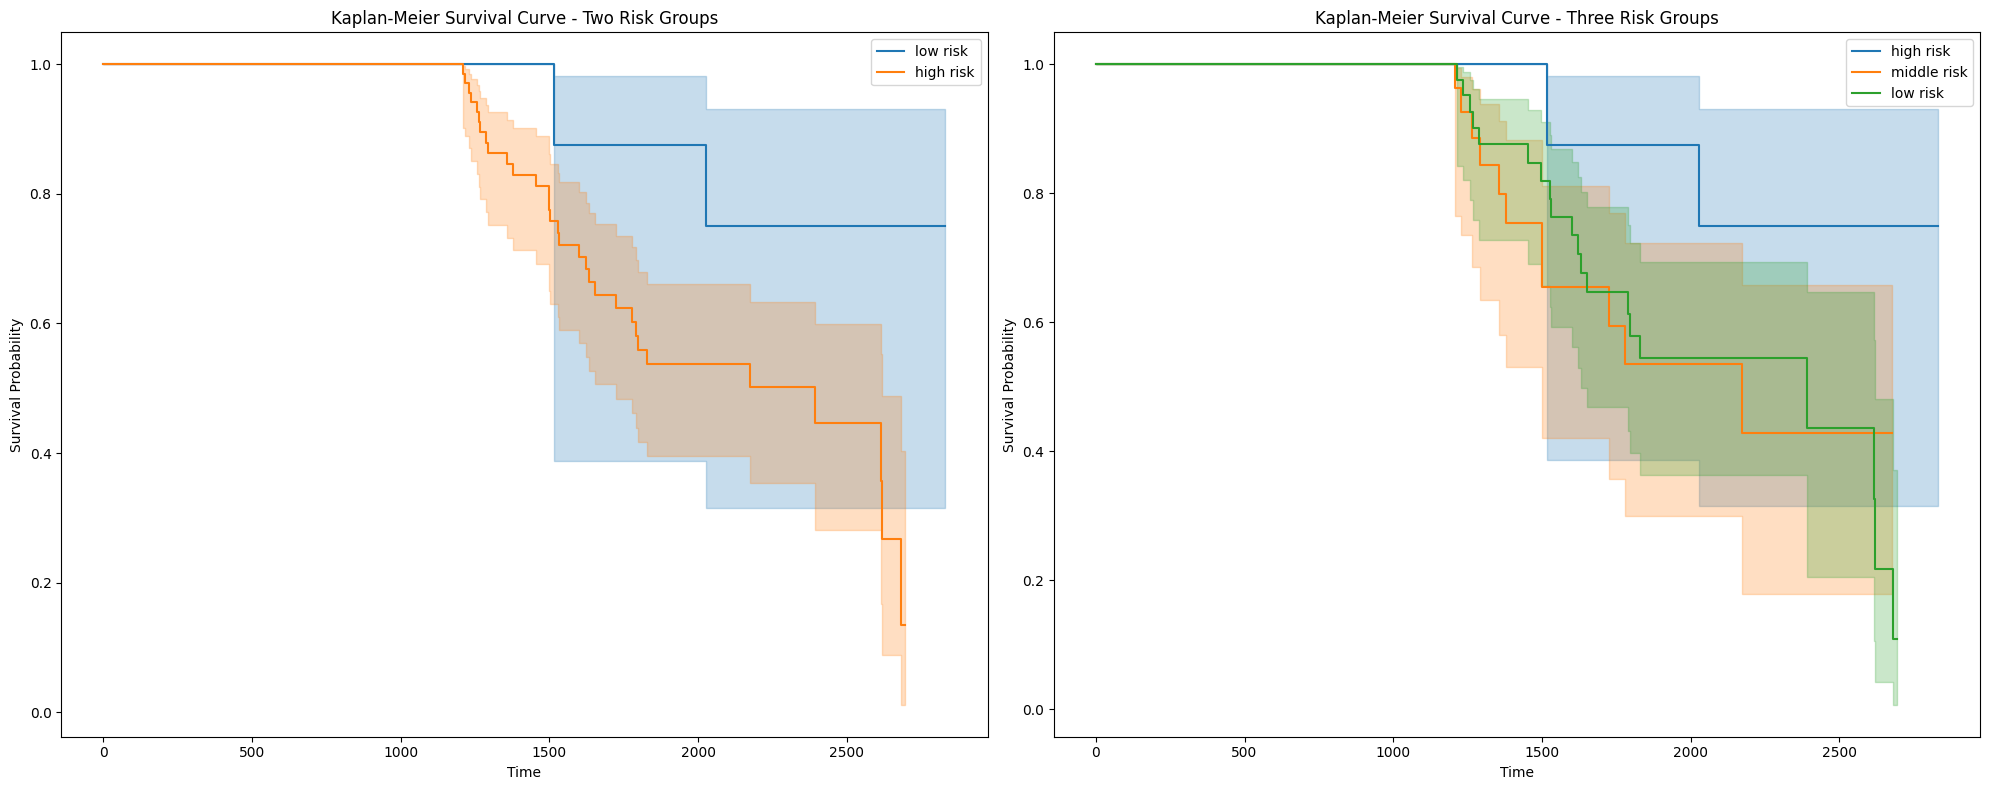

In [14]:
#Because the average survival time for cancer pacient is around 2000 days, so we restrict the overall survival time to less than 2000 days.

filtered = merged_data[merged_data['overall_survival'] < 3000]
filtered_df = filtered[filtered['overall_survival']>1200]


new_df = filtered_df.drop(columns=['overall_survival', 'status'])
numeric_data_new = new_df.select_dtypes(include=[np.number])

# Hierarchical clustering
linked = linkage(numeric_data_new, 'ward')



label_2_clusters = fcluster(linked, 2, criterion='maxclust')
label_3_clusters = fcluster(linked, 3, criterion='maxclust')




filtered_df['risk_group_2'] = label_2_clusters
filtered_df['risk_group_3'] = label_3_clusters


kmf = KaplanMeierFitter()

# For 2 risk groups
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
risk_labels_2 = {1: "low risk", 2: "high risk"}
for label in np.unique(label_2_clusters):
    mask = filtered_df['risk_group_2'] == label
    group_data = filtered_df[mask]

    kmf.fit(group_data['overall_survival'], event_observed=group_data['status'], label=risk_labels_2[label])
    kmf.plot(ax=plt.gca())

plt.title('Kaplan-Meier Survival Curve - Two Risk Groups')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# For 3 risk groups
plt.subplot(1, 2, 2)
risk_labels_3 = {1: "high risk", 2: "middle risk", 3: "low risk"}
for label in np.unique(label_3_clusters):
    mask = filtered_df['risk_group_3'] == label
    group_data = filtered_df[mask]

    kmf.fit(group_data['overall_survival'], event_observed=group_data['status'], label=risk_labels_3[label])
    kmf.plot(ax=plt.gca())

plt.title('Kaplan-Meier Survival Curve - Three Risk Groups')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

plt.tight_layout()
plt.show()


In [15]:
from lifelines.statistics import logrank_test

# calculate 2 risk groups p-value
group1 = filtered_df[filtered_df['risk_group_2'] == 1]
group2 = filtered_df[filtered_df['risk_group_2'] == 2]
results_2 = logrank_test(group1['overall_survival'], group2['overall_survival'], event_observed_A=group1['status'], event_observed_B=group2['status'])
p_value_2 = results_2.p_value
print(f"P-value : {p_value_2}")

P-value : 0.06133316173066136


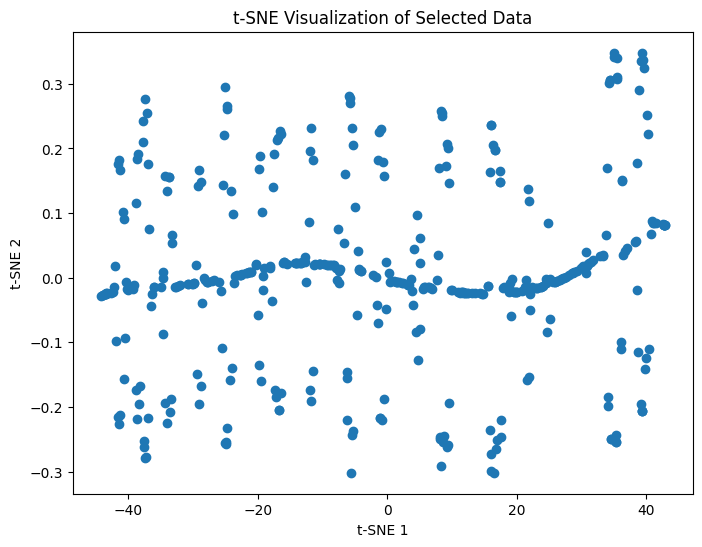

In [16]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt



# Select and set up the data
selected_data = merged_data.iloc[:, -3:]



# Applying t-SNE
tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(selected_data)

# Visualizing the results
plt.figure(figsize=(8, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE Visualization of Selected Data')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


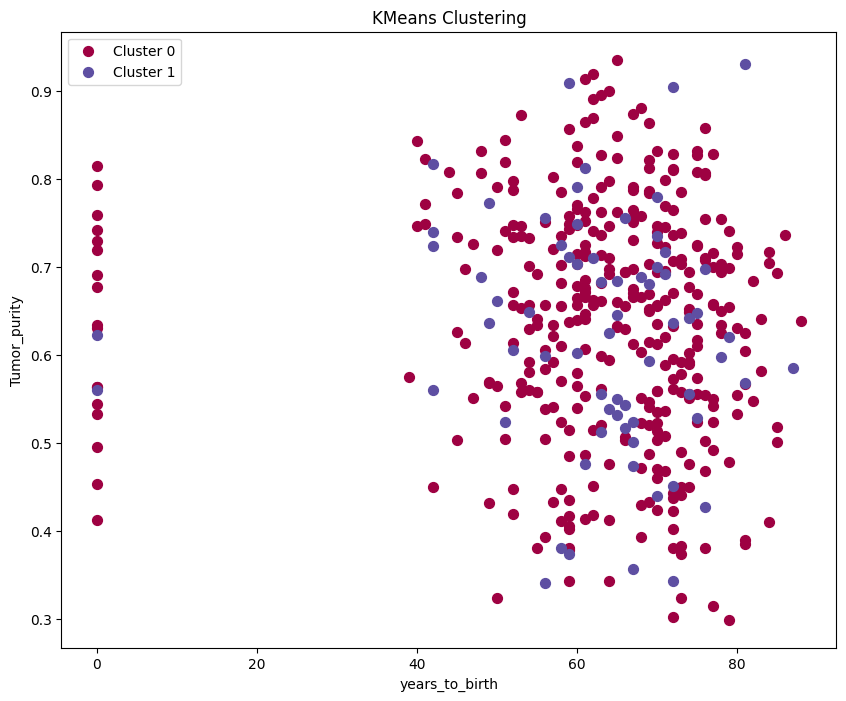

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# 选择数据
selected_data = merged_data.iloc[:, -3:]
selected_data.set_index(merged_data["attrib_name"], inplace=True)

# 对 selected_data 进行 KMeans 聚类, 假设我们选择 5 作为簇的数量，您可以根据需要调整
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(selected_data)

# 创建 merged_data 的副本并加入聚类结果
merged_data_copy2 = merged_data.copy()
merged_data_copy2.set_index("attrib_name", inplace=True)
merged_data_copy2['cluster'] = clusters

# 获取簇标签
labels = np.unique(clusters)

colors = plt.cm.Spectral(np.linspace(0, 1, len(labels)))

# 使用 merged_data_copy1 的某两个特征进行可视化，这里我假设使用前两列作为示例
feature_x = merged_data_copy2.columns[0]
feature_y = merged_data_copy2.columns[1]

plt.figure(figsize=(10, 8))
for cluster_label, color in zip(labels, colors):
    cluster_data = merged_data_copy2[merged_data_copy2['cluster'] == cluster_label]
    plt.scatter(cluster_data[feature_x], cluster_data[feature_y], color=color, s=50, label=f'Cluster {cluster_label}')

plt.title('KMeans Clustering')
plt.xlabel(feature_x)
plt.ylabel(feature_y)
plt.legend()
plt.show()


In [18]:
attributes = [
    'pathologic_stage',
    'pathology_N_stage',
    'pathology_M_stage',
    'pathology_T_stage',
    'pathology_T_stage',
    'radiation_therapy'
]

for attribute in attributes:
    stage_counts = merged_data_copy2.groupby('cluster')[attribute].value_counts()
    stage_counts = stage_counts.unstack(fill_value=0)
    print(stage_counts)

pathologic_stage  No value  stagei  stageii  stageiii  stageiv
cluster                                                       
0                        5     191       86        60       18
1                        0      39       17        10        2
pathology_N_stage  No value   n0  n1  n2  n3
cluster                                     
0                         9  234  63  53   1
1                         0   45  14   9   0
pathology_M_stage  No value   m0  m1
cluster                             
0                       119  224  17
1                        23   43   2
pathology_T_stage  No value   t1   t2  t3  t4
cluster                                      
0                         3  124  187  33  13
1                         0   23   38   4   3
pathology_T_stage  No value   t1   t2  t3  t4
cluster                                      
0                         3  124  187  33  13
1                         0   23   38   4   3
radiation_therapy  No value   no  yes
cluster       

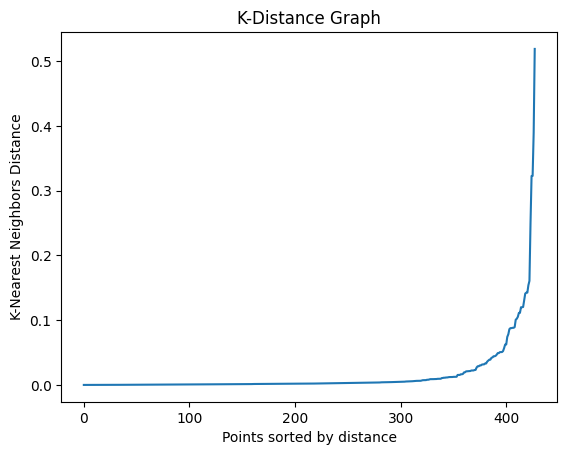

In [19]:
from sklearn.neighbors import NearestNeighbors
selected_data = merged_data.iloc[:, -3:]
selected_data.set_index(merged_data["attrib_name"], inplace=True)

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(selected_data)
distances, indices = nbrs.kneighbors(selected_data)

distances = np.sort(distances, axis=0)
distances = distances[:, 1]
plt.plot(distances)
plt.ylabel('K-Nearest Neighbors Distance')
plt.xlabel('Points sorted by distance')
plt.title('K-Distance Graph')
plt.show()


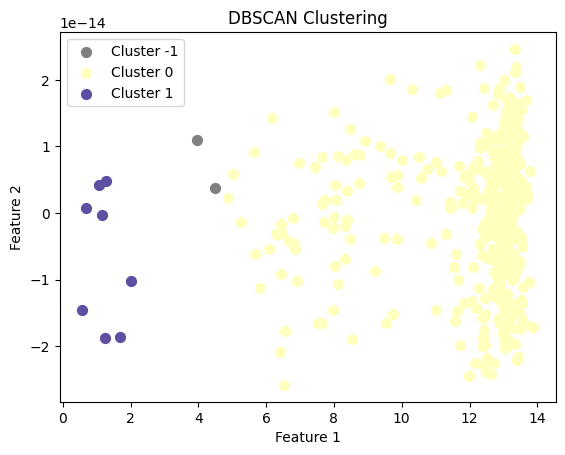

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN


# 假设 selected_data 是你要聚类的数据
data_to_cluster = selected_data.copy()

# 使用DBSCAN进行聚类
dbscan = DBSCAN(eps=0.6, min_samples=5)

data_to_cluster['cluster'] = dbscan.fit_predict(data_to_cluster)

# 获取簇的标签
labels = np.unique(data_to_cluster['cluster'])

colors = plt.cm.Spectral(np.linspace(0, 1, len(labels)))

# 画出每个簇
for cluster_label, color in zip(labels, colors):
    if cluster_label == -1:  # 噪音点
        color = 'gray'
    cluster_data = data_to_cluster[data_to_cluster['cluster'] == cluster_label]
    plt.scatter(cluster_data.iloc[:, 0], cluster_data.iloc[:, 1], color=color, s=50, label=f'Cluster {cluster_label}')

plt.title('DBSCAN Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()


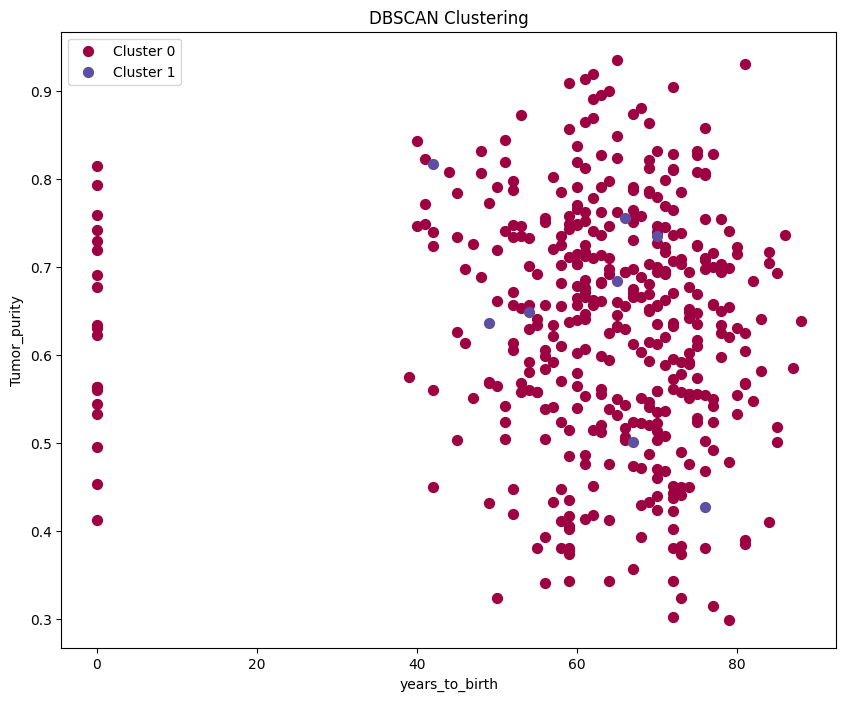

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# 选择数据
selected_data = merged_data.iloc[:, -3:]
selected_data.set_index(merged_data["attrib_name"], inplace=True)

# 对 selected_data 进行 DBSCAN 聚类
dbscan = DBSCAN(eps=0.8, min_samples=5)
clusters = dbscan.fit_predict(selected_data)

# 创建 merged_data 的副本并加入聚类结果
merged_data_copy1 = merged_data.copy()
merged_data_copy1.set_index("attrib_name", inplace=True)
merged_data_copy1['cluster'] = clusters

# 获取簇标签
labels = np.unique(clusters)

colors = plt.cm.Spectral(np.linspace(0, 1, len(labels)))

# 使用 merged_data_copy1 的某两个特征进行可视化，这里我假设使用前两列作为示例
feature_x = merged_data_copy1.columns[0]
feature_y = merged_data_copy1.columns[1]

plt.figure(figsize=(10, 8))
for cluster_label, color in zip(labels, colors):
    if cluster_label == -1:  # 噪音点
        color = 'gray'

    cluster_data = merged_data_copy1[merged_data_copy1['cluster'] == cluster_label]
    plt.scatter(cluster_data[feature_x], cluster_data[feature_y], color=color, s=50, label=f'Cluster {cluster_label}')

plt.title('DBSCAN Clustering')
plt.xlabel(feature_x)
plt.ylabel(feature_y)
plt.legend()
plt.show()


In [22]:
attributes = [
    'years_to_birth',
    'Tumor_purity',
    'pathologic_stage',
    'histological_type',
    'residual_tumor',
    'pathologic_stage',
    'pathology_N_stage',
    'pathology_M_stage',
    'pathology_T_stage',
    'radiation_therapy'
]
for attribute in attributes:
    stage_counts = merged_data_copy1.groupby('cluster')[attribute].value_counts()
    stage_counts = stage_counts.unstack(fill_value=0)
    print(stage_counts)


years_to_birth  0.0   39.0  40.0  41.0  42.0  44.0  45.0  46.0  47.0  48.0  \
cluster                                                                      
0                 19     1     2     3     4     1     4     2     2     3   
1                  0     0     0     0     1     0     0     0     0     0   

years_to_birth  ...  79.0  80.0  81.0  82.0  83.0  84.0  85.0  86.0  87.0  \
cluster         ...                                                         
0               ...     6     5     7     2     2     3     3     1     1   
1               ...     0     0     0     0     0     0     0     0     0   

years_to_birth  88.0  
cluster               
0                  1  
1                  0  

[2 rows x 50 columns]
Tumor_purity  0.2992  0.3025  0.3147  0.3242  0.3411  0.3431  0.3563  0.3734  \
cluster                                                                        
0                  1       1       1       2       1       3       1       1   
1                  0   

In [23]:
# order by 'Tumor_purity'
found = False
df = merged_data_copy1.sort_values(by='Tumor_purity')


for value in df['Tumor_purity']:

    count_0_before = len(df[(df['Tumor_purity'] < value) & (df['cluster'] == 0)])
    count_0_after = len(df[(df['Tumor_purity'] >= value) & (df['cluster'] == 0)])
    count_1_before = len(df[(df['Tumor_purity'] < value) & (df['cluster'] == 1)])
    count_1_after = len(df[(df['Tumor_purity'] >= value) & (df['cluster'] == 1)])


    if count_0_before > count_1_before and count_0_after < count_1_after:
        print(f"The value {value} satisfies the condition.")
        found = True
        break
if not found:
    print("No value satisfies the condition.")


No value satisfies the condition.


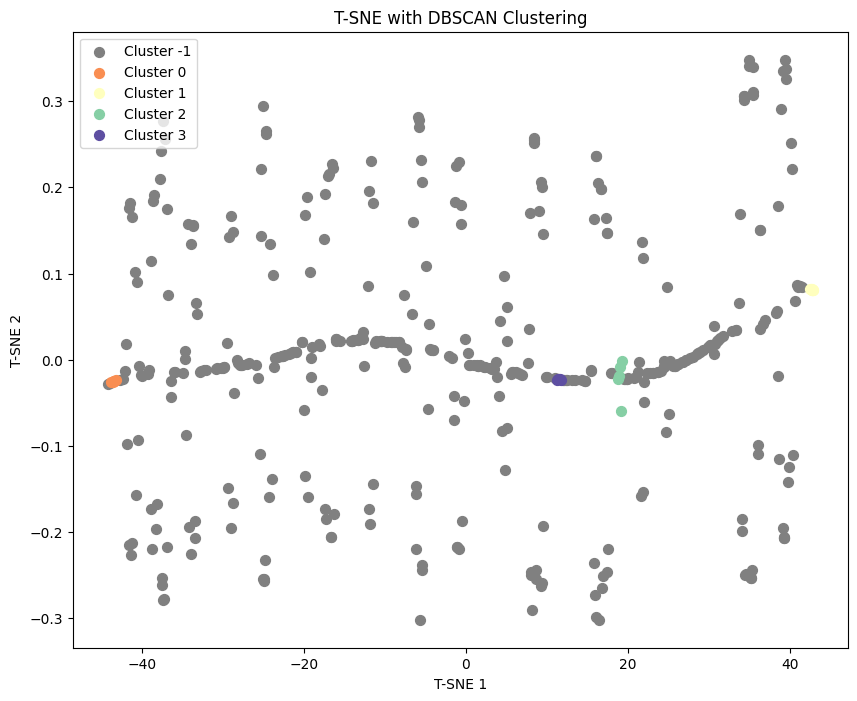

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE

selected_data = merged_data.iloc[:, -3:]
selected_data.set_index(merged_data["attrib_name"], inplace=True)

# 使用 T-SNE 进行降维
tsne = TSNE(n_components=2, random_state=42)
tsne_transformed = tsne.fit_transform(selected_data)

# 使用 DBSCAN 进行聚类
dbscan = DBSCAN(eps=0.25, min_samples=5)
clusters = dbscan.fit_predict(tsne_transformed)

# 创建 merged_data 的副本，并将 clusters 添加为一个新的列
merged_data_copy = merged_data.copy()
merged_data_copy.set_index("attrib_name", inplace=True)  # 保证索引与 selected_data 一致
merged_data_copy['cluster'] = clusters

# 获取簇的标签
labels = np.unique(clusters)

colors = plt.cm.Spectral(np.linspace(0, 1, len(labels)))

# 使用 T-SNE 降维的数据进行可视化
plt.figure(figsize=(10, 8))
for cluster_label, color in zip(labels, colors):
    if cluster_label == -1:  # 噪音点
        color = 'gray'

    mask = clusters == cluster_label
    plt.scatter(tsne_transformed[mask, 0], tsne_transformed[mask, 1], color=color, s=50, label=f'Cluster {cluster_label}')

plt.title('T-SNE with DBSCAN Clustering')
plt.xlabel('T-SNE 1')
plt.ylabel('T-SNE 2')
plt.legend()
plt.show()



In [25]:
merged_data_copy

,years_to_birth,Tumor_purity,pathologic_stage,pathology_T_stage,pathology_N_stage,pathology_M_stage,histological_type,gender,radiation_therapy,residual_tumor,race,ethnicity,overall_survival,status,overallsurvival,0,1,2,3,cluster
attrib_name,,,,,,,,,,,,,,,,,,,,
TCGA.05.4384,66.0,0.6937,stageiii,t2,n2,m0,lungadenocarcinomamixedsubtype,male,yes,No value,No value,No value,426.0,0.0,"426,0",19.996500,12.396028,-1.575148e-14,2.281373e-16,-1
TCGA.05.4384,66.0,0.6937,stageiii,t2,n2,m0,lungadenocarcinomamixedsubtype,male,yes,No value,No value,No value,426.0,0.0,"426,0",19.996500,12.396028,-1.575148e-14,2.281373e-16,-1
TCGA.05.4396,76.0,0.8575,stageiii,t4,n1,m0,lungadenocarcinomamixedsubtype,male,No value,r0,No value,No value,303.0,1.0,"303,1",20.943601,13.679057,-1.688260e-14,-2.371713e-16,0
TCGA.05.4405,74.0,0.5920,stagei,t2,n0,m0,lungadenocarcinomamixedsubtype,female,no,r0,No value,No value,610.0,0.0,"610,0",21.834325,13.320472,-1.412922e-14,-1.469516e-16,-1
TCGA.05.4427,65.0,0.6325,stageii,t2,n1,m0,lungadenocarcinomamixedsubtype,female,no,r0,No value,No value,791.0,0.0,"791,0",20.506906,13.113854,-1.219977e-14,-2.730942e-16,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA.NJ.A4YQ,69.0,0.4331,stagei,t1,n0,m0,lungadenocarcinoma-nototherwisespecified(nos),female,no,No value,white,nothispanicorlatino,1432.0,0.0,"1432,0",24.198474,12.686010,1.118778e-14,3.703455e-16,-1
TCGA.NJ.A55R,67.0,0.7913,stagei,t1,n0,No value,lungadenocarcinoma-nototherwisespecified(nos),male,no,No value,white,nothispanicorlatino,603.0,0.0,"603,0",21.390161,13.211211,5.296641e-16,2.762684e-16,-1
TCGA.NJ.A7XG,49.0,0.7730,stageiii,t4,n1,m0,lungadenocarcinoma-nototherwisespecified(nos),male,no,No value,blackorafricanamerican,nothispanicorlatino,617.0,0.0,"617,0",20.861224,7.968359,-1.450833e-14,4.466422e-16,-1


In [26]:
# 检查 merged_data_copy 中是否有NA值
if merged_data_copy.isna().any().any():
    print("Detected NA values. Dropping...")
    merged_data_copy.dropna(inplace=True)
else:
    print("No NA values detected.")


No NA values detected.


In [30]:
#print("DBSCAN result: eps: " + str(eps) +", min_samples: "+str(min_samples))

attributes = [
    'pathologic_stage',
    'pathology_N_stage',
    'pathology_M_stage',
    'pathology_T_stage',


]

for attribute in attributes:
    stage_counts = merged_data_copy.groupby('cluster')[attribute].value_counts()
    stage_counts = stage_counts.unstack(fill_value=0)
    print(stage_counts)


pathologic_stage  No value  stagei  stageii  stageiii  stageiv
cluster                                                       
-1                       5     218       98        64       19
 0                       0       2        2         2        0
 1                       0       6        2         0        0
 2                       0       2        0         2        1
 3                       0       2        1         2        0
pathology_N_stage  No value   n0  n1  n2  n3
cluster                                     
-1                        8  263  74  59   0
 0                        0    4   1   1   0
 1                        0    7   1   0   0
 2                        1    2   0   1   1
 3                        0    3   1   1   0
pathology_M_stage  No value   m0  m1
cluster                             
-1                      132  254  18
 0                        3    3   0
 1                        2    6   0
 2                        2    2   1
 3                    